<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-NLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-NLinear']

In [5]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['online-learning-NLinear']['seq_len'])
        self.pred_len = int(configs['online-learning-NLinear']['pred_len'])
        self.channels = int(configs['online-learning-NLinear']['enc_in'])
        self.individual = configs['online-learning-NLinear']['individual']
        self.device = torch.device('cuda:0')
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        # https://bo-10000.tistory.com/181
        x = (x-seq_last)
        seq_last = seq_last.to(self.device)
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1).to(self.device)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [6]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [7]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_498735/1396078320.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)


In [8]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


In [9]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [10]:
target.size()

torch.Size([27360, 1, 1])

In [11]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq.permute(0,2,1))
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')       

Adjusting learning rate of group 0 to 9.5000e-06.
smape 15.908383212504331 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 13.992395902499123 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 13.034852956209267 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 12.46206530876327 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 12.107875732301968 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 11.859944959917264 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 11.658255621703745 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 11.490197092381834 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 11.341772716906336 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 11.207019725912495 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 11.086274012487534 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 10.97894246030969 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 10.880093581059523 %
A

In [12]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.593579325824976 %
SMAPE 22.084009289741516 %
SMAPE 9.745872370898724 %
SMAPE 1.228479160927236 %
SMAPE 9.911571100354195 %
SMAPE 11.376344814896584 %
SMAPE 1.883947804570198 %
SMAPE 3.9534960202872753 %
SMAPE 4.78103668987751 %
SMAPE 3.8166391290724277 %
SMAPE 0.35556823085062206 %
SMAPE 16.370987460017204 %
SMAPE 6.471207179129124 %
SMAPE 2.0657407958060503 %
SMAPE 10.149986110627651 %
SMAPE 1.387649143114686 %
SMAPE 10.736109174787998 %
SMAPE 8.281278818845749 %
SMAPE 1.187757609412074 %
SMAPE 0.7848734436556697 %
SMAPE 7.254555098712443 %
SMAPE 10.829791255295277 %
SMAPE 5.446526020765305 %
SMAPE 9.323735229671001 %
SMAPE 6.119058463722467 %
SMAPE 7.904062248766422 %
SMAPE 10.650366023182869 %
SMAPE 1.6061711702495813 %
SMAPE 3.5108613893389697 %
SMAPE 11.851697348058224 %
SMAPE 11.820679545402527 %
SMAPE 12.387417510151863 %
SMAPE 5.1576266176998615 %
SMAPE 7.3573815673589715 %
SMAPE 1.7850659787654877 %
SMAPE 7.200175397098064 %
SMAPE 10.422277189791203 %
SMAPE 2.528198882

SMAPE 0.015707552650269463 %
SMAPE 10.458585649728775 %
SMAPE 2.3675666898489 %
SMAPE 6.200634315609932 %
SMAPE 14.232301026582716 %
SMAPE 6.237972244620323 %
SMAPE 11.224864207208157 %
SMAPE 3.656614728271961 %
SMAPE 3.4471638575196266 %
SMAPE 5.843791849911213 %
SMAPE 0.494916645810008 %
SMAPE 12.289996482431889 %
SMAPE 0.6639034147374332 %
SMAPE 4.964398644864559 %
SMAPE 3.3407881706953053 %
SMAPE 0.36492449860088527 %
SMAPE 11.063371948897839 %
SMAPE 5.000527419149876 %
SMAPE 12.026482328772545 %
SMAPE 9.583964362740517 %
SMAPE 6.888057582080364 %
SMAPE 18.42189782857895 %
SMAPE 0.4773588036186993 %
SMAPE 3.6914388425648212 %
SMAPE 0.951162022538483 %
SMAPE 1.6417934093624353 %
SMAPE 10.021085239946842 %
SMAPE 0.5458679674193263 %
SMAPE 3.060527950525284 %
SMAPE 4.39689214900136 %
SMAPE 5.943229656666517 %
SMAPE 10.118820495903492 %
SMAPE 1.6444687582552433 %
SMAPE 4.271701376885176 %
SMAPE 11.93042279779911 %
SMAPE 2.404046442359686 %
SMAPE 15.17990343272686 %
SMAPE 10.56880941241

SMAPE 6.012880582362413 %
SMAPE 2.728588657453656 %
SMAPE 2.751277457922697 %
SMAPE 5.979544699192047 %
SMAPE 11.91065988689661 %
SMAPE 7.949426665902138 %
SMAPE 2.069288607686758 %
SMAPE 2.80257797986269 %
SMAPE 2.8588563557714224 %
SMAPE 10.11193261295557 %
SMAPE 13.059457495808601 %
SMAPE 7.879350513219833 %
SMAPE 0.009082127682631835 %
SMAPE 8.903704896569252 %
SMAPE 13.062524378299715 %
SMAPE 7.8012680411338815 %
SMAPE 2.603690877556801 %
SMAPE 2.9861587714403868 %
SMAPE 4.514781299978495 %
SMAPE 3.3124674074351788 %
SMAPE 2.108713947236538 %
SMAPE 5.320165436714888 %
SMAPE 1.9808614179491997 %
SMAPE 7.229044526815414 %
SMAPE 10.954549290239811 %
SMAPE 10.60007581114769 %
SMAPE 6.403680741786958 %
SMAPE 0.6349042542278767 %
SMAPE 5.1016432531178 %
SMAPE 2.2411868683993816 %
SMAPE 3.59623771160841 %
SMAPE 6.895203709602356 %
SMAPE 2.8065170627087355 %
SMAPE 13.720516622066498 %
SMAPE 10.827143914997578 %
SMAPE 9.210645839571953 %
SMAPE 7.263556391000748 %
SMAPE 4.056592296808958 %


SMAPE 7.445859268307686 %
SMAPE 3.238930352032185 %
SMAPE 2.9580688010901213 %
SMAPE 5.9600659646093845 %
SMAPE 12.448025219142437 %
SMAPE 5.498043555766344 %
SMAPE 5.762394566088915 %
SMAPE 2.1229034326970577 %
SMAPE 2.3759585302323103 %
SMAPE 2.0949389096349478 %
SMAPE 0.7325218073092401 %
SMAPE 3.958184737712145 %
SMAPE 2.8286717142909765 %
SMAPE 5.7228484228253365 %
SMAPE 4.2970970422029495 %
SMAPE 1.8251825608313084 %
SMAPE 2.242856975644827 %
SMAPE 6.667260617017747 %
SMAPE 6.845244638621807 %
SMAPE 3.5177588574588294 %
SMAPE 3.306259650737047 %
SMAPE 3.417573448270559 %
SMAPE 1.3827439341694117 %
SMAPE 5.942975860089064 %
SMAPE 14.680245652794838 %
SMAPE 4.008178986608982 %
SMAPE 6.914308562874794 %
SMAPE 4.825526982545853 %
SMAPE 1.55119957216084 %
SMAPE 2.8974011298269033 %
SMAPE 10.072507865726948 %
SMAPE 5.663496989756823 %
SMAPE 4.3370196633040905 %
SMAPE 1.4194725416600704 %
SMAPE 12.580185666680336 %
SMAPE 8.307738222181797 %
SMAPE 6.2069454081356525 %
SMAPE 2.73294910229

SMAPE 3.9091091603040695 %
SMAPE 7.650608018040657 %
SMAPE 3.1928815394639964 %
SMAPE 11.220154464244843 %
SMAPE 7.07186446338892 %
SMAPE 14.110146656632425 %
SMAPE 0.9965630481019616 %
SMAPE 5.9047167003154755 %
SMAPE 5.959937006235123 %
SMAPE 8.48687644302845 %
SMAPE 1.2883178545162082 %
SMAPE 3.0250503290444613 %
SMAPE 3.894469365477562 %
SMAPE 7.713169515132905 %
SMAPE 4.156079415231943 %
SMAPE 8.69459193944931 %
SMAPE 3.6040435694158073 %
SMAPE 1.5807622028514743 %
SMAPE 0.25976576562970877 %
SMAPE 0.4310489660128951 %
SMAPE 12.511635787785053 %
SMAPE 7.9127068519592285 %
SMAPE 7.738440997898579 %
SMAPE 0.47783442167565227 %
SMAPE 13.697609677910805 %
SMAPE 2.3389369398355484 %
SMAPE 5.482002671808004 %
SMAPE 7.08974115550518 %
SMAPE 7.045737899839878 %
SMAPE 7.056632064282894 %
SMAPE 7.342690832912922 %
SMAPE 3.8545418232679367 %
SMAPE 3.580059479922056 %
SMAPE 0.4574941955506801 %
SMAPE 9.008648678660393 %
SMAPE 2.540350405499339 %
SMAPE 2.647509453818202 %
SMAPE 1.2684973161667

SMAPE 4.720335811376572 %
SMAPE 0.8637238685041666 %
SMAPE 1.2425792096182704 %
SMAPE 1.5448227934539318 %
SMAPE 8.573731921613216 %
SMAPE 3.5168825052678585 %
SMAPE 0.7539439350366592 %
SMAPE 2.955653501674533 %
SMAPE 0.8210584348998964 %
SMAPE 2.620780596509576 %
SMAPE 20.363936111330986 %
SMAPE 6.638908915221692 %
SMAPE 2.702189162373543 %
SMAPE 0.8867465788498521 %
SMAPE 5.1261190846562386 %
SMAPE 2.6046368833631277 %
SMAPE 3.1393807064741845 %
SMAPE 4.236259415745735 %
SMAPE 3.529570136219263 %
SMAPE 5.446426894515753 %
SMAPE 7.651811450719833 %
SMAPE 7.157931953668594 %
SMAPE 4.321119546890259 %
SMAPE 11.542021356523037 %
SMAPE 7.277114704251289 %
SMAPE 9.976311407983303 %
SMAPE 1.4487246880307794 %
SMAPE 1.5353629123419523 %
SMAPE 2.13552388548851 %
SMAPE 12.938335433602333 %
SMAPE 3.877245131880045 %
SMAPE 9.287355966866016 %
SMAPE 2.7180470526218414 %
SMAPE 11.046983726322651 %
SMAPE 6.176690265536308 %
SMAPE 10.016261249780655 %
SMAPE 1.35824600700289 %
SMAPE 2.05357690155506

SMAPE 16.863955855369568 %
SMAPE 1.7807288896292448 %
SMAPE 6.121273472905159 %
SMAPE 10.249790526926517 %
SMAPE 2.28283504024148 %
SMAPE 1.1100778160616755 %
SMAPE 16.0827946215868 %
SMAPE 4.356666538864374 %
SMAPE 1.7010512873530388 %
SMAPE 2.659017601981759 %
SMAPE 10.23318237066269 %
SMAPE 2.1836835965514183 %
SMAPE 5.416587136685848 %
SMAPE 13.068464100360872 %
SMAPE 5.388478819280863 %
SMAPE 1.4568945784121752 %
SMAPE 0.44508642004802823 %
SMAPE 0.5334082911722362 %
SMAPE 1.479842172935605 %
SMAPE 3.8474631495773792 %
SMAPE 6.761261053383351 %
SMAPE 7.213004231452942 %
SMAPE 2.3709428813308477 %
SMAPE 2.5387738198041916 %
SMAPE 3.564864456653595 %
SMAPE 5.315739024430513 %
SMAPE 0.2852888598572463 %
SMAPE 4.547790303826332 %
SMAPE 7.493064172565937 %
SMAPE 4.727618210017681 %
SMAPE 10.988481052219868 %
SMAPE 7.723171353340148 %
SMAPE 0.5418188315816224 %
SMAPE 7.0877418294549 %
SMAPE 3.929758444428444 %
SMAPE 1.1290352111682296 %
SMAPE 6.837606467306615 %
SMAPE 1.2609505951404572

SMAPE 9.41705995798111 %
SMAPE 3.3570871800184245 %
SMAPE 1.038150112144649 %
SMAPE 7.5277731865644455 %
SMAPE 4.14511276781559 %
SMAPE 1.0055672554299235 %
SMAPE 1.5549820214509964 %
SMAPE 5.066756270825863 %
SMAPE 6.84523493796587 %
SMAPE 1.0559506267309189 %
SMAPE 1.4456953117623925 %
SMAPE 0.021965221739634444 %
SMAPE 0.5149572207592428 %
SMAPE 2.636246293783188 %
SMAPE 2.164799941703677 %
SMAPE 2.376543214544654 %
SMAPE 3.1653664018958807 %
SMAPE 3.228209499269724 %
SMAPE 0.5741589283570647 %
SMAPE 1.6941310223191977 %
SMAPE 7.4942673444747925 %
SMAPE 3.2248829342424874 %
SMAPE 2.1329045556485653 %
SMAPE 5.07396150380373 %
SMAPE 7.3115335404872885 %
SMAPE 2.753132928162813 %
SMAPE 0.14543796877842396 %
SMAPE 2.5921155754476786 %
SMAPE 1.277859477326274 %
SMAPE 1.9617774356156588 %
SMAPE 2.1096040699630976 %
SMAPE 2.2229411732405424 %
SMAPE 3.29173693805933 %
SMAPE 0.5738285593688488 %
SMAPE 3.9481354281306267 %
SMAPE 4.211853437125683 %
SMAPE 4.096909254789352 %
SMAPE 2.2322665546

SMAPE 1.9188557714223862 %
SMAPE 0.058863006968749694 %
SMAPE 0.6778222336433828 %
SMAPE 0.6583555075339973 %
SMAPE 8.099785700440407 %
SMAPE 0.14167186641134322 %
SMAPE 6.25055442005396 %
SMAPE 0.471051627304405 %
SMAPE 6.768684513866901 %
SMAPE 3.3897312544286256 %
SMAPE 2.222839957103133 %
SMAPE 9.238856084644794 %
SMAPE 4.374897740781307 %
SMAPE 0.5868540983647108 %
SMAPE 8.712453559041023 %
SMAPE 2.700161959975958 %
SMAPE 6.206090465188026 %
SMAPE 0.7937939008697867 %
SMAPE 3.241727504879236 %
SMAPE 3.209482107311487 %
SMAPE 5.810942154377699 %
SMAPE 8.64514109492302 %
SMAPE 10.090609200298786 %
SMAPE 1.8999654836952686 %
SMAPE 12.615554422140121 %
SMAPE 1.6834230963140726 %
SMAPE 1.5234261527657509 %
SMAPE 6.714639283716678 %
SMAPE 3.980344109237194 %
SMAPE 3.9953965172171593 %
SMAPE 3.58213372156024 %
SMAPE 6.425997145473956 %
SMAPE 9.749853178858757 %
SMAPE 5.283188633620739 %
SMAPE 11.04909860342741 %
SMAPE 3.8893014453351498 %
SMAPE 4.230100583285093 %
SMAPE 6.288175992667674

SMAPE 0.7759008528664708 %
SMAPE 2.9554826971143484 %
SMAPE 15.873379826545717 %
SMAPE 0.4512290243292227 %
SMAPE 0.2930800027679652 %
SMAPE 2.542550962418318 %
SMAPE 1.4288118248805404 %
SMAPE 3.7084184996783733 %
SMAPE 4.648921802639961 %
SMAPE 6.144583683460951 %
SMAPE 2.268782038241625 %
SMAPE 2.2602360378950834 %
SMAPE 0.8117807060480119 %
SMAPE 2.3932634741067886 %
SMAPE 0.651357885915786 %
SMAPE 7.873678639531136 %
SMAPE 6.578554809093476 %
SMAPE 0.4408848902676255 %
SMAPE 3.8846379630267625 %
SMAPE 3.029859570786357 %
SMAPE 3.82519555464387 %
SMAPE 0.7546762516722083 %
SMAPE 0.11780320008983837 %
SMAPE 0.23644773801788688 %
SMAPE 1.1758144898340106 %
SMAPE 2.9338823165744543 %
SMAPE 1.6633171737194061 %
SMAPE 1.1217281743884087 %
SMAPE 6.096146855503321 %
SMAPE 6.960199475288391 %
SMAPE 2.336648266762495 %
SMAPE 4.704719617962837 %
SMAPE 16.960177272558212 %
SMAPE 3.572871793061495 %
SMAPE 5.421888645738363 %
SMAPE 0.10355467423914888 %
SMAPE 0.31080797454342246 %
SMAPE 0.68967

SMAPE 1.700906103476882 %
SMAPE 0.7883573141880333 %
SMAPE 0.8687088042497635 %
SMAPE 3.5399538613855834 %
SMAPE 0.5339284823276103 %
SMAPE 0.5740331369452178 %
SMAPE 9.772610574960709 %
SMAPE 5.088412016630173 %
SMAPE 2.0312939677387476 %
SMAPE 5.811513006687164 %
SMAPE 1.7688469085842369 %
SMAPE 1.5558718563988805 %
SMAPE 2.7954518292099237 %
SMAPE 1.6191020924597979 %
SMAPE 1.8966597076505423 %
SMAPE 3.587177693843842 %
SMAPE 7.951424293220042 %
SMAPE 19.64291326701641 %
SMAPE 19.477758511900902 %
SMAPE 5.438482359051704 %
SMAPE 1.6499040238559244 %
SMAPE 1.815800366923213 %
SMAPE 2.1876422446221113 %
SMAPE 6.038064245134592 %
SMAPE 8.568115293979645 %
SMAPE 6.375425562262535 %
SMAPE 9.310503624379635 %
SMAPE 8.721807703375816 %
SMAPE 3.4327348060905933 %
SMAPE 2.2022090572863817 %
SMAPE 0.2943885636050254 %
SMAPE 3.082335026934743 %
SMAPE 4.003616485744715 %
SMAPE 1.9203390870243313 %
SMAPE 1.064253244549036 %
SMAPE 5.0930317640304565 %
SMAPE 7.651303790509701 %
SMAPE 8.71636298298

SMAPE 6.858923800289631 %
SMAPE 1.6597815155982971 %
SMAPE 2.2945333290845156 %
SMAPE 1.5735627841204403 %
SMAPE 1.2898094998672605 %
SMAPE 2.361968094483018 %
SMAPE 7.31471049785614 %
SMAPE 1.626352597028017 %
SMAPE 3.2033987455070014 %
SMAPE 2.4799053333699703 %
SMAPE 0.6991604221984744 %
SMAPE 4.64985054731369 %
SMAPE 4.609514705836773 %
SMAPE 14.30772502720356 %
SMAPE 2.2136610373854637 %
SMAPE 0.5936273084953427 %
SMAPE 5.060629460960627 %
SMAPE 2.5220341105014086 %
SMAPE 0.43099488131701946 %
SMAPE 4.755074422806501 %
SMAPE 0.5988935763016343 %
SMAPE 3.6511484533548355 %
SMAPE 4.020217653363943 %
SMAPE 2.3325267005711794 %
SMAPE 5.435693632811308 %
SMAPE 3.37723695486784 %
SMAPE 5.661865457892418 %
SMAPE 0.5083394721150398 %
SMAPE 1.5545899104326963 %
SMAPE 2.6225067526102066 %
SMAPE 0.10855951387202367 %
SMAPE 2.6855437867343426 %
SMAPE 1.6623615492135286 %
SMAPE 1.1124450964853168 %
SMAPE 0.46945235738530755 %
SMAPE 1.3945052018389106 %
SMAPE 0.8291862281039357 %
SMAPE 0.713785

SMAPE 1.3511255364865065 %
SMAPE 8.352309942245483 %
SMAPE 1.5708726365119219 %
SMAPE 6.334763057529927 %
SMAPE 4.712066192179918 %
SMAPE 3.5287635400891304 %
SMAPE 0.7845302014611661 %
SMAPE 3.323152553290129 %
SMAPE 2.3770253844559193 %
SMAPE 2.6390572749078274 %
SMAPE 2.083848474547267 %
SMAPE 10.147247783839703 %
SMAPE 2.583379762247205 %
SMAPE 1.8645077217370272 %
SMAPE 0.07091120972472709 %
SMAPE 1.7904378287494183 %
SMAPE 4.551654081791639 %
SMAPE 1.0129088526591659 %
SMAPE 2.1903339568525553 %
SMAPE 5.038890775293112 %
SMAPE 5.056203007698059 %
SMAPE 1.636996438726783 %
SMAPE 6.09986349567771 %
SMAPE 8.096961051225662 %
SMAPE 11.245418332517147 %
SMAPE 6.078688610345125 %
SMAPE 0.45493791438639164 %
SMAPE 0.9909927677363157 %
SMAPE 9.97837071865797 %
SMAPE 0.4843393489718437 %
SMAPE 1.6489645149558783 %
SMAPE 3.915224689990282 %
SMAPE 4.21486359462142 %
SMAPE 7.451282650232314 %
SMAPE 0.05134359567500724 %
SMAPE 2.030535213649273 %
SMAPE 6.2542648427188405 %
SMAPE 2.18757528252

SMAPE 1.8365882448852062 %
SMAPE 6.534893698990345 %
SMAPE 6.500053070485593 %
SMAPE 3.0247735641896725 %
SMAPE 0.6208381047472358 %
SMAPE 1.4938604347407818 %
SMAPE 0.44390039099380374 %
SMAPE 6.8883413299918175 %
SMAPE 3.8834013678133488 %
SMAPE 0.2982342289760709 %
SMAPE 8.859576486051083 %
SMAPE 1.7166771609336138 %
SMAPE 1.6102528218179941 %
SMAPE 0.8884483771398664 %
SMAPE 3.0819004829972982 %
SMAPE 1.5428232615813613 %
SMAPE 1.8365677166730165 %
SMAPE 8.706502996385098 %
SMAPE 5.688408754765987 %
SMAPE 2.8744421172887087 %
SMAPE 2.2674703150987625 %
SMAPE 0.16925969382282346 %
SMAPE 15.014488086104393 %
SMAPE 1.3981139110401273 %
SMAPE 7.726388342678547 %
SMAPE 2.7562360875308514 %
SMAPE 7.744699068367482 %
SMAPE 4.6856849528849125 %
SMAPE 0.4320823180023581 %
SMAPE 0.7638901281170547 %
SMAPE 2.7995240204036236 %
SMAPE 0.5008186702616513 %
SMAPE 2.5214774161577225 %
SMAPE 4.784193057566881 %
SMAPE 0.928254220634699 %
SMAPE 0.7113928440958261 %
SMAPE 2.025561837479472 %
SMAPE 6.4

SMAPE 1.7794216480106115 %
SMAPE 5.172089975327253 %
SMAPE 0.0781455701824143 %
SMAPE 2.68934409879148 %
SMAPE 1.1247451240196824 %
SMAPE 3.232452224940061 %
SMAPE 0.78267468418926 %
SMAPE 0.8202549181878566 %
SMAPE 3.604075498878956 %
SMAPE 0.6173299900256097 %
SMAPE 4.359300460666418 %
SMAPE 5.636130593717098 %
SMAPE 11.135229632258415 %
SMAPE 4.517750553786755 %
SMAPE 3.5657988265156746 %
SMAPE 3.4155573286116123 %
SMAPE 3.040319385007024 %
SMAPE 2.1974004935473204 %
SMAPE 6.69314631074667 %
SMAPE 3.359348736703396 %
SMAPE 3.7895803228020672 %
SMAPE 1.3211002573370934 %
SMAPE 4.142153978347778 %
SMAPE 2.4593707490712404 %
SMAPE 0.786759412381798 %
SMAPE 9.231990687549114 %
SMAPE 5.833333685994148 %
SMAPE 0.039362840858018444 %
SMAPE 4.945576690137386 %
SMAPE 3.3417559564113617 %
SMAPE 0.4087158439215272 %
SMAPE 9.433289907872677 %
SMAPE 2.4510560911148787 %
SMAPE 7.600872740149497 %
SMAPE 2.2635040413588285 %
SMAPE 3.645901620388031 %
SMAPE 4.324286632239819 %
SMAPE 3.63239928334951

SMAPE 9.092434361577034 %
SMAPE 1.9215455316007137 %
SMAPE 2.195440514013171 %
SMAPE 13.562310263514519 %
SMAPE 0.8727992298081516 %
SMAPE 0.40132233453914523 %
SMAPE 8.749545477330685 %
SMAPE 15.350844621658325 %
SMAPE 4.931637234985828 %
SMAPE 2.292598968371749 %
SMAPE 1.016003062017262 %
SMAPE 0.6499006515368819 %
SMAPE 3.1607751119881873 %
SMAPE 0.44955522310920054 %
SMAPE 4.379345837980509 %
SMAPE 3.0765524189919233 %
SMAPE 16.38565656542778 %
SMAPE 15.060677096247673 %
SMAPE 7.2308755069971085 %
SMAPE 2.890188880264759 %
SMAPE 3.714624278247356 %
SMAPE 0.08808686134580057 %
SMAPE 0.404743968276307 %
SMAPE 9.218925669789314 %
SMAPE 1.1753091868013144 %
SMAPE 2.133890191093087 %
SMAPE 12.410419777035713 %
SMAPE 12.496394462883472 %
SMAPE 3.2214414477348323 %
SMAPE 0.30774875450879335 %
SMAPE 3.478230018168688 %
SMAPE 2.9484043456614017 %
SMAPE 2.000325122848153 %
SMAPE 22.097938537597656 %
SMAPE 1.3536391835659742 %
SMAPE 0.6364895985461771 %
SMAPE 14.107532262802124 %
SMAPE 12.976

SMAPE 4.475190423429012 %
SMAPE 0.07589034921147686 %
SMAPE 0.41626731539145106 %
SMAPE 3.357131589204073 %
SMAPE 1.6204098761081693 %
SMAPE 8.460832014679909 %
SMAPE 11.299999140203 %
SMAPE 3.086418990045786 %
SMAPE 6.896903589367867 %
SMAPE 1.3392284587025642 %
SMAPE 5.012354660779238 %
SMAPE 4.697366189211607 %
SMAPE 0.624491214286536 %
SMAPE 0.495451342780143 %
SMAPE 0.6304761455394328 %
SMAPE 5.744671914726496 %
SMAPE 2.352788193151355 %
SMAPE 1.1000133361667395 %
SMAPE 5.617108393460512 %
SMAPE 1.3217174587771297 %
SMAPE 3.61115450784564 %
SMAPE 0.4044086299836635 %
SMAPE 0.8858252475038171 %
SMAPE 7.601016521453857 %
SMAPE 0.08400146412031972 %
SMAPE 3.7932033166289325 %
SMAPE 4.115873202681541 %
SMAPE 2.4666206408292055 %
SMAPE 2.7458077035844326 %
SMAPE 3.1846102252602577 %
SMAPE 4.303664617240429 %
SMAPE 1.7772037275135517 %
SMAPE 3.036213943734765 %
SMAPE 5.109938457608223 %
SMAPE 0.8983607785776258 %
SMAPE 4.897658064961433 %
SMAPE 4.991352193057537 %
SMAPE 3.43149267137050

SMAPE 1.611611995846033 %
SMAPE 3.7279714196920395 %
SMAPE 0.1581647724378854 %
SMAPE 2.879819681867957 %
SMAPE 5.300615832209587 %
SMAPE 0.05864671916930319 %
SMAPE 1.7070677373558285 %
SMAPE 1.6754317246377468 %
SMAPE 13.470864564180374 %
SMAPE 2.9735262151807547 %
SMAPE 0.36299383314326406 %
SMAPE 8.532383844256401 %
SMAPE 6.003224439918995 %
SMAPE 10.413863442838192 %
SMAPE 4.950981423258781 %
SMAPE 11.257663182914257 %
SMAPE 1.34870664216578 %
SMAPE 7.446915909647942 %
SMAPE 2.737903229892254 %
SMAPE 6.873841479420662 %
SMAPE 0.35418075299821794 %
SMAPE 0.61795226437971 %
SMAPE 6.040555812418461 %
SMAPE 0.661118901334703 %
SMAPE 9.210108555853367 %
SMAPE 0.6764371213503182 %
SMAPE 4.6648364663124084 %
SMAPE 4.5353600680828094 %
SMAPE 7.153283789753914 %
SMAPE 0.7803614647127688 %
SMAPE 5.658483825623989 %
SMAPE 2.2558287139981985 %
SMAPE 5.559909213334322 %
SMAPE 4.082656443119049 %
SMAPE 10.61474795639515 %
SMAPE 0.6829114146530628 %
SMAPE 3.712702676653862 %
SMAPE 5.187869947403

SMAPE 0.1364829435478896 %
SMAPE 2.077031336724758 %
SMAPE 2.3802007529884577 %
SMAPE 9.322964236140251 %
SMAPE 2.3261009696871042 %
SMAPE 6.577329836785793 %
SMAPE 0.6903622425161302 %
SMAPE 3.1006042156368494 %
SMAPE 4.758183836936951 %
SMAPE 1.0428691804409027 %
SMAPE 1.1345030600205064 %
SMAPE 5.822188254445791 %
SMAPE 3.1259811520576477 %
SMAPE 4.246093600988388 %
SMAPE 2.7337537482380867 %
SMAPE 4.467811282724142 %
SMAPE 7.402313560247421 %
SMAPE 4.7601039707660675 %
SMAPE 1.714817464351654 %
SMAPE 6.440323352813721 %
SMAPE 0.049115842281025834 %
SMAPE 2.1266225147992373 %
SMAPE 3.368184573948383 %
SMAPE 3.189055144786835 %
SMAPE 5.378642022609711 %
SMAPE 1.2529850043356419 %
SMAPE 2.083424234762788 %
SMAPE 4.203049801290035 %
SMAPE 2.655166933313012 %
SMAPE 5.467278517782688 %
SMAPE 1.310040632262826 %
SMAPE 4.749178528785706 %
SMAPE 8.675975561141968 %
SMAPE 3.0690241996198893 %
SMAPE 6.583245642483234 %
SMAPE 3.9556443095207214 %
SMAPE 3.650866288691759 %
SMAPE 6.6960720047354

SMAPE 0.15576240350492299 %
SMAPE 6.190602581948042 %
SMAPE 3.01864411868155 %
SMAPE 0.3882108358666301 %
SMAPE 5.802007760852575 %
SMAPE 0.43534423992969096 %
SMAPE 4.570151619613171 %
SMAPE 3.5022851936519146 %
SMAPE 3.45105304941535 %
SMAPE 0.7560978140681982 %
SMAPE 1.0462860083207488 %
SMAPE 3.036078345030546 %
SMAPE 1.2262567402794957 %
SMAPE 1.1143829766660929 %
SMAPE 2.3843668792396784 %
SMAPE 0.9565685503184795 %
SMAPE 1.80489918962121 %
SMAPE 6.311445273458957 %
SMAPE 4.3646994680166245 %
SMAPE 5.272352360188961 %
SMAPE 4.732029903680086 %
SMAPE 6.772778615355492 %
SMAPE 1.8562883976846931 %
SMAPE 8.352211982011795 %
SMAPE 6.929075807332992 %
SMAPE 0.31968796043656766 %
SMAPE 3.366833191365003 %
SMAPE 17.379810512065887 %
SMAPE 11.621178895235062 %
SMAPE 1.8753893785178661 %
SMAPE 5.071022089570761 %
SMAPE 1.7848056331276891 %
SMAPE 2.2596834301948547 %
SMAPE 15.571483835577965 %
SMAPE 12.470060609281063 %
SMAPE 2.6693313848227262 %
SMAPE 8.008513785898685 %
SMAPE 7.942995049

SMAPE 3.6981796249747276 %
SMAPE 2.393221076577902 %
SMAPE 4.255864396691322 %
SMAPE 8.904109559953213 %
SMAPE 9.469464883208275 %
SMAPE 0.7254293286241591 %
SMAPE 0.24574479856528342 %
SMAPE 6.945796817541122 %
SMAPE 0.896725338883698 %
SMAPE 2.5752503238618374 %
SMAPE 1.036194046959281 %
SMAPE 0.06623571514501236 %
SMAPE 1.2241694815456867 %
SMAPE 0.0810864906234201 %
SMAPE 7.141854807734489 %
SMAPE 3.0548750925809145 %
SMAPE 0.17904649942647666 %
SMAPE 11.653362929821014 %
SMAPE 14.129750922322273 %
SMAPE 2.545781884342432 %
SMAPE 8.54997181147337 %
SMAPE 4.008495341986418 %
SMAPE 4.532944418489933 %
SMAPE 8.595237843692303 %
SMAPE 3.936746321618557 %
SMAPE 11.77834801375866 %
SMAPE 5.18634545430541 %
SMAPE 7.092922814190388 %
SMAPE 5.918181348592043 %
SMAPE 1.0972707914188504 %
SMAPE 1.0411818623542786 %
SMAPE 2.5701431948691607 %
SMAPE 2.133569274097681 %
SMAPE 5.631455298513174 %
SMAPE 7.638026751577855 %
SMAPE 12.707768663764 %
SMAPE 10.239294737577438 %
SMAPE 10.773184187710285

SMAPE 8.788170725107193 %
SMAPE 1.6627864949405193 %
SMAPE 11.459520980715752 %
SMAPE 5.402921933680773 %
SMAPE 1.5260237343609333 %
SMAPE 0.27844674908556044 %
SMAPE 2.679073954001069 %
SMAPE 5.7485824637115 %
SMAPE 0.4738678955473006 %
SMAPE 8.780156761407852 %
SMAPE 0.9195212917402387 %
SMAPE 3.24110160395503 %
SMAPE 1.2578293038532138 %
SMAPE 4.6908555924892426 %
SMAPE 4.893809653818607 %
SMAPE 2.058406511321664 %
SMAPE 1.3016518075019121 %
SMAPE 7.310678973793984 %
SMAPE 3.467400666326284 %
SMAPE 4.088564813137054 %
SMAPE 2.5786784384399652 %
SMAPE 0.002797288381337637 %
SMAPE 3.7626343183219433 %
SMAPE 1.132654543966055 %
SMAPE 2.3569450322538614 %
SMAPE 5.948217689990997 %
SMAPE 3.24056027084589 %
SMAPE 7.1699387058615685 %
SMAPE 6.466522909700871 %
SMAPE 0.34040788607671857 %
SMAPE 2.2671336960047483 %
SMAPE 1.0630911448970437 %
SMAPE 1.262956827878952 %
SMAPE 0.9873960539698601 %
SMAPE 4.367629677057266 %
SMAPE 3.1017776653170586 %
SMAPE 5.555580608546734 %
SMAPE 0.52037555165

SMAPE 4.0201320350170135 %
SMAPE 2.6699187606573105 %
SMAPE 3.4620883502066135 %
SMAPE 0.02203692389986145 %
SMAPE 1.7032214384526017 %
SMAPE 1.7836342155933378 %
SMAPE 9.874591059982777 %
SMAPE 6.252314999699593 %
SMAPE 4.69528104364872 %
SMAPE 0.3396247182972729 %
SMAPE 4.5363823510706425 %
SMAPE 1.806354407221079 %
SMAPE 5.2660641968250275 %
SMAPE 1.5992119666188953 %
SMAPE 3.154022235423327 %
SMAPE 2.531639350578189 %
SMAPE 2.2939742151647806 %
SMAPE 0.29279386531561613 %
SMAPE 0.0596934724599123 %
SMAPE 6.361388102173805 %
SMAPE 6.033962544053793 %
SMAPE 3.5711780712008476 %
SMAPE 2.3835238348692656 %
SMAPE 1.065621668472886 %
SMAPE 2.5033384673297405 %
SMAPE 8.582158751785755 %
SMAPE 1.8912219423800707 %
SMAPE 0.4618085604161024 %
SMAPE 0.1813382605323568 %
SMAPE 1.9359731487929819 %
SMAPE 3.1510447598993774 %
SMAPE 1.1006293771788478 %
SMAPE 7.899945415556431 %
SMAPE 3.361147347837687 %
SMAPE 5.437840241938829 %
SMAPE 7.5659723952412605 %
SMAPE 2.3239434845745564 %
SMAPE 2.16433

SMAPE 4.386731307953596 %
SMAPE 1.6242258381098509 %
SMAPE 0.5555597175844014 %
SMAPE 3.284208621829748 %
SMAPE 5.132362492382526 %
SMAPE 5.04623980820179 %
SMAPE 8.049573682248592 %
SMAPE 3.572748549282551 %
SMAPE 3.2538584768772125 %
SMAPE 10.874104730784893 %
SMAPE 7.283344730734825 %
SMAPE 6.3676583021879205 %
SMAPE 8.175244241952896 %
SMAPE 0.016223956670643247 %
SMAPE 5.727080374956131 %
SMAPE 5.599534932523966 %
SMAPE 12.344548113644123 %
SMAPE 0.46461919415742164 %
SMAPE 3.229713659733534 %
SMAPE 2.420199727639556 %
SMAPE 7.077546499669552 %
SMAPE 0.04358897743935586 %
SMAPE 4.491033609956503 %
SMAPE 3.813128907233477 %
SMAPE 6.345248840749264 %
SMAPE 1.7718560732901096 %
SMAPE 5.821537736803293 %
SMAPE 1.2161730825901031 %
SMAPE 6.539641350507735 %
SMAPE 0.48980214167386293 %
SMAPE 2.2978238742798567 %
SMAPE 0.9003467923030257 %
SMAPE 3.192321386188269 %
SMAPE 3.044058484956622 %
SMAPE 2.8352576456964016 %
SMAPE 1.9769005309790373 %
SMAPE 3.6929377391934395 %
SMAPE 2.626845868

SMAPE 11.885238766670227 %
SMAPE 1.3000971050933003 %
SMAPE 0.11237480555428192 %
SMAPE 1.1337750563398004 %
SMAPE 2.8284834008663893 %
SMAPE 1.6109123565256596 %
SMAPE 2.362256469205022 %
SMAPE 7.487887345254421 %
SMAPE 3.7111678645014767 %
SMAPE 21.225326538085938 %
SMAPE 10.90157886594534 %
SMAPE 0.6283308411948383 %
SMAPE 3.8956340067088604 %
SMAPE 7.695691175758839 %
SMAPE 4.522504311054945 %
SMAPE 1.129761228337884 %
SMAPE 0.9850235152989627 %
SMAPE 0.8620527451857923 %
SMAPE 1.5121117737144232 %
SMAPE 2.1405539996922016 %
SMAPE 8.553992509841919 %
SMAPE 2.610562190413475 %
SMAPE 6.284165721386671 %
SMAPE 9.039347149431705 %
SMAPE 0.9390532644465566 %
SMAPE 4.956398613750935 %
SMAPE 0.9403924206271768 %
SMAPE 5.926702037453651 %
SMAPE 14.520255744457245 %
SMAPE 4.194261401891708 %
SMAPE 1.8180486466735601 %
SMAPE 0.7341243852861226 %
SMAPE 0.16130312450695783 %
SMAPE 0.12594626960344613 %
SMAPE 4.102196540683508 %
SMAPE 0.15440340409986675 %
SMAPE 2.8149180728942156 %
SMAPE 6.637

SMAPE 6.184227555990219 %
SMAPE 2.2081461027264595 %
SMAPE 0.6354486299678683 %
SMAPE 0.29376589180901647 %
SMAPE 8.956990487873554 %
SMAPE 1.8319153860211372 %
SMAPE 5.270133439451456 %
SMAPE 0.5492731877602637 %
SMAPE 0.9673083787783981 %
SMAPE 1.1543374164029956 %
SMAPE 0.7147459415718913 %
SMAPE 0.36268080584704876 %
SMAPE 0.00046326901546933646 %
SMAPE 1.5658890847116709 %
SMAPE 0.8622291143983601 %
SMAPE 4.379887580871582 %
SMAPE 6.012463290244341 %
SMAPE 2.6964761912822723 %
SMAPE 0.8255035118199885 %
SMAPE 7.697139926254749 %
SMAPE 4.35264828056097 %
SMAPE 3.2765555195510387 %
SMAPE 0.5678287679329515 %
SMAPE 1.1348016820847988 %
SMAPE 1.3673121351748705 %
SMAPE 2.6238638069480658 %
SMAPE 2.4618214052170515 %
SMAPE 4.175797637552023 %
SMAPE 4.989164985716343 %
SMAPE 8.131068304181099 %
SMAPE 0.07647659312351607 %
SMAPE 4.023443199694157 %
SMAPE 3.205575440078974 %
SMAPE 5.599162612110376 %
SMAPE 5.708905845880508 %
SMAPE 0.3270403111819178 %
SMAPE 1.3712194440886378 %
SMAPE 4.3

SMAPE 3.5863442532718186 %
SMAPE 5.203514792025089 %
SMAPE 3.998875465244055 %
SMAPE 1.5850532818585634 %
SMAPE 4.399764578789473 %
SMAPE 0.45450929226353765 %
SMAPE 3.5627393871545796 %
SMAPE 6.806653328239917 %
SMAPE 10.350898832082748 %
SMAPE 6.634775057435036 %
SMAPE 1.2396465940400958 %
SMAPE 0.20429836213588715 %
SMAPE 2.9442533664405346 %
SMAPE 1.2148777469992638 %
SMAPE 4.048036064952612 %
SMAPE 1.535041406750679 %
SMAPE 2.1751748621463776 %
SMAPE 0.3886875838506967 %
SMAPE 1.1971941329538822 %
SMAPE 2.8112550359219313 %
SMAPE 0.589731500018388 %
SMAPE 0.957176323980093 %
SMAPE 4.836905777454376 %
SMAPE 1.0906281154602766 %
SMAPE 1.8723440058529377 %
SMAPE 3.536165058612824 %
SMAPE 8.151488788425922 %
SMAPE 0.816599971614778 %
SMAPE 3.9654634706676 %
SMAPE 6.3099570125341415 %
SMAPE 2.7187560107558966 %
SMAPE 3.2126565873622894 %
SMAPE 0.1632971412036568 %
SMAPE 2.8700372762978077 %
SMAPE 1.6213935958221557 %
SMAPE 2.033049937337637 %
SMAPE 3.428155392408371 %
SMAPE 12.06188311

SMAPE 4.255500588566065 %
SMAPE 1.2776397969573736 %
SMAPE 1.7373833730816843 %
SMAPE 3.4051203429698944 %
SMAPE 2.399922190234065 %
SMAPE 2.834903545677662 %
SMAPE 5.705084040760994 %
SMAPE 2.5502390321344137 %
SMAPE 4.149051282554865 %
SMAPE 2.6563779190182686 %
SMAPE 2.179970696568489 %
SMAPE 3.770518958568573 %
SMAPE 4.164403051137924 %
SMAPE 5.024981342256069 %
SMAPE 0.43643684522248805 %
SMAPE 0.9490704443305732 %
SMAPE 4.082571696490049 %
SMAPE 3.2858021818101406 %
SMAPE 8.7331687733531 %
SMAPE 1.625498102977872 %
SMAPE 1.8220180682837963 %
SMAPE 1.0739161120727658 %
SMAPE 5.708587158471346 %
SMAPE 0.18044031306635588 %
SMAPE 5.781419686973095 %
SMAPE 0.8104453361593187 %
SMAPE 1.2331827180460095 %
SMAPE 1.1995222065597773 %
SMAPE 7.360252231359482 %
SMAPE 2.072888847440481 %
SMAPE 6.258790608495474 %
SMAPE 3.80778132006526 %
SMAPE 3.6250778399407864 %
SMAPE 0.2325982938054949 %
SMAPE 5.960891537368298 %
SMAPE 4.105861492455006 %
SMAPE 5.718580853193998 %
SMAPE 9.817404679954052

SMAPE 4.187781181186438 %
SMAPE 6.254280500113964 %
SMAPE 3.9967036433517933 %
SMAPE 2.5555435847491026 %
SMAPE 0.5702502587810159 %
SMAPE 1.3399256533011794 %
SMAPE 1.686616851016879 %
SMAPE 1.4109183242544532 %
SMAPE 2.2007322534918785 %
SMAPE 1.5101206405088305 %
SMAPE 0.47146290028467774 %
SMAPE 1.004253489896655 %
SMAPE 10.356995582580566 %
SMAPE 0.33983620908111334 %
SMAPE 2.540873061865568 %
SMAPE 3.793425157666206 %
SMAPE 1.3929537935182452 %
SMAPE 4.866456009447575 %
SMAPE 3.2468127720057964 %
SMAPE 2.1944022141397 %
SMAPE 1.575918572023511 %
SMAPE 4.874477565288544 %
SMAPE 0.9072964936494827 %
SMAPE 4.814550958573818 %
SMAPE 5.612579222768545 %
SMAPE 2.8923046942800283 %
SMAPE 8.51233097165823 %
SMAPE 1.1762529145926237 %
SMAPE 6.499402627348899 %
SMAPE 4.030806627124548 %
SMAPE 7.5670704916119576 %
SMAPE 5.326071064919233 %
SMAPE 2.729456325992942 %
SMAPE 7.0683710649609575 %
SMAPE 0.7105066757649183 %
SMAPE 5.299222022294998 %
SMAPE 4.531390093266964 %
SMAPE 3.2604186236858

SMAPE 22.63676229119301 %
SMAPE 12.213906444609165 %
SMAPE 2.771141018718481 %
SMAPE 1.643321607261896 %
SMAPE 4.1200687773525715 %
SMAPE 11.007292337715626 %
SMAPE 7.399331904947758 %
SMAPE 3.405837059020996 %
SMAPE 1.6476233005523682 %
SMAPE 2.7101571522653103 %
SMAPE 7.294481620192528 %
SMAPE 0.3640293241478503 %
SMAPE 3.952632650732994 %
SMAPE 13.088631138205528 %
SMAPE 3.875984083861113 %
SMAPE 3.4880532696843143 %
SMAPE 4.279264945536852 %
SMAPE 10.522263057529926 %
SMAPE 7.718692950904369 %
SMAPE 2.586654791608453 %
SMAPE 5.262009587138891 %
SMAPE 17.43445047736168 %
SMAPE 7.855632364749908 %
SMAPE 9.91195847839117 %
SMAPE 25.656961351633072 %
SMAPE 5.944978188723326 %
SMAPE 4.544670786708593 %
SMAPE 9.073987409472466 %
SMAPE 13.48506973683834 %
SMAPE 1.5266020009294152 %
SMAPE 0.03197184697228295 %
SMAPE 2.00161493383348 %
SMAPE 0.11395169812021778 %
SMAPE 4.718061231076717 %
SMAPE 3.551212102174759 %
SMAPE 0.3385054194368422 %
SMAPE 0.9560250071808696 %
SMAPE 2.612602697685361

SMAPE 23.976468592882156 %
SMAPE 6.684512622654439 %
SMAPE 2.9015669636428356 %
SMAPE 1.6143365222960713 %
SMAPE 5.413429893553257 %
SMAPE 6.164129264652729 %
SMAPE 1.0491418903693557 %
SMAPE 3.2447383515536785 %
SMAPE 0.19624745787587017 %
SMAPE 0.34298969712108374 %
SMAPE 4.752921726554632 %
SMAPE 0.7999808369204402 %
SMAPE 0.6294866632670164 %
SMAPE 3.2741213142871857 %
SMAPE 7.968986071646214 %
SMAPE 13.046709001064299 %
SMAPE 8.996314629912376 %
SMAPE 2.236895453184843 %
SMAPE 4.306007269769907 %
SMAPE 3.3868452422320847 %
SMAPE 5.201888702809811 %
SMAPE 8.026271060109138 %
SMAPE 4.2246361300349236 %
SMAPE 1.6258660200983286 %
SMAPE 6.092686835676432 %
SMAPE 4.169672183692455 %
SMAPE 4.308471117168665 %
SMAPE 2.5272661559283733 %
SMAPE 9.706619799137115 %
SMAPE 11.565578199923038 %
SMAPE 26.169288009405133 %
SMAPE 1.8368282821029425 %
SMAPE 13.566043734550476 %
SMAPE 5.609346278011799 %
SMAPE 3.7216357365250587 %
SMAPE 6.585478022694588 %
SMAPE 2.5363559927791357 %
SMAPE 4.7814593

SMAPE 7.67254540324211 %
SMAPE 1.5584080815315247 %
SMAPE 2.4662871919572353 %
SMAPE 1.8420240320265295 %
SMAPE 6.193620070815086 %
SMAPE 0.2038794024847448 %
SMAPE 2.3262811340391636 %
SMAPE 3.2953071743249893 %
SMAPE 7.61451943218708 %
SMAPE 3.6405630260705952 %
SMAPE 3.605158593505621 %
SMAPE 0.33937601931393147 %
SMAPE 1.3028202094137669 %
SMAPE 0.15744401200208813 %
SMAPE 1.3753525018692017 %
SMAPE 1.6766098346561193 %
SMAPE 2.580689689144492 %
SMAPE 1.7051649894565344 %
SMAPE 4.993481315672398 %
SMAPE 4.587659612298012 %
SMAPE 2.6806180719286203 %
SMAPE 1.9247411154210567 %
SMAPE 1.4549314649775624 %
SMAPE 3.22335884347558 %
SMAPE 2.6720464043319225 %
SMAPE 2.527835689485073 %
SMAPE 5.6364702470600605 %
SMAPE 1.0467393584549427 %
SMAPE 2.474449386820197 %
SMAPE 1.892369881272316 %
SMAPE 1.400023433379829 %
SMAPE 1.0542817264795303 %
SMAPE 1.1568741090595722 %
SMAPE 5.257467992603779 %
SMAPE 2.2332487367093563 %
SMAPE 7.188600689172745 %
SMAPE 6.008563067764044 %
SMAPE 16.32895116

SMAPE 7.131223239004612 %
SMAPE 2.0044099763035774 %
SMAPE 9.616536036133766 %
SMAPE 5.602779623121023 %
SMAPE 3.57452405616641 %
SMAPE 13.000063538551332 %
SMAPE 5.242391284555197 %
SMAPE 9.620265446603298 %
SMAPE 0.7281255084089935 %
SMAPE 6.959439888596535 %
SMAPE 10.84301581978798 %
SMAPE 3.2718196772038937 %
SMAPE 3.140881203114986 %
SMAPE 8.327522151172161 %
SMAPE 18.968721359968185 %
SMAPE 15.991407886147499 %
SMAPE 2.2854876052588224 %
SMAPE 7.972474180161954 %
SMAPE 3.5698363855481148 %
SMAPE 8.785910055041313 %
SMAPE 1.0055081630125642 %
SMAPE 6.317189261317253 %
SMAPE 6.586788520216942 %
SMAPE 5.753252629190683 %
SMAPE 16.742581218481064 %
SMAPE 8.951555386185646 %
SMAPE 2.135622337460518 %
SMAPE 1.6860030014067888 %
SMAPE 5.008115109056234 %
SMAPE 2.8536335304379463 %
SMAPE 1.875068051740527 %
SMAPE 6.78822723776102 %
SMAPE 3.7828790508210663 %
SMAPE 1.2940444042906165 %
SMAPE 19.802638664841652 %
SMAPE 1.925936223939061 %
SMAPE 3.8298649266362195 %
SMAPE 13.723253667354584

In [13]:
target=list(target.values.reshape(-1))

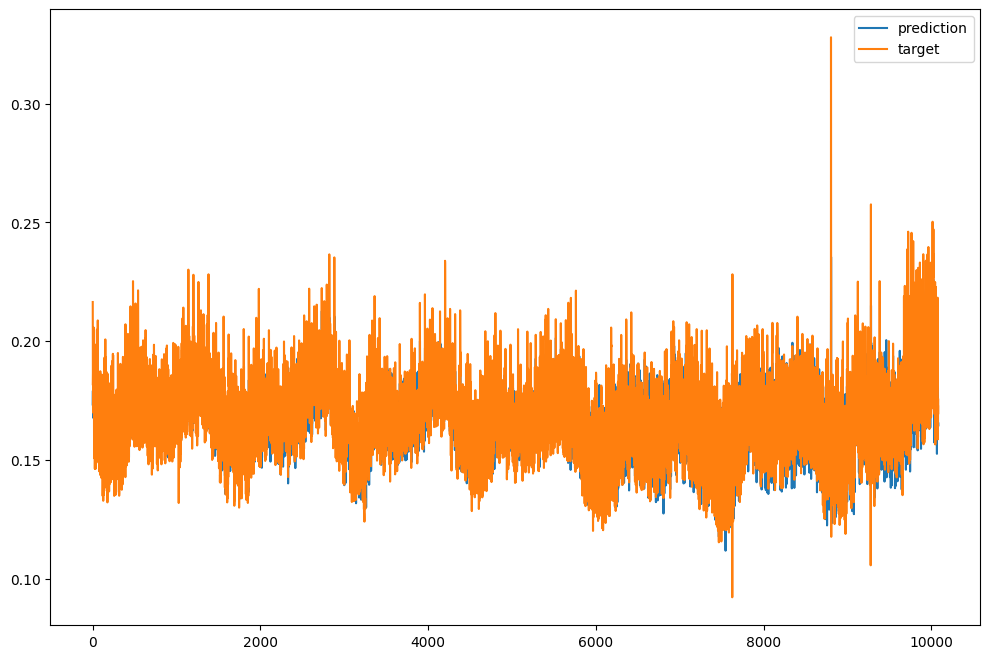

In [14]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [15]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 4.505013942718506 %


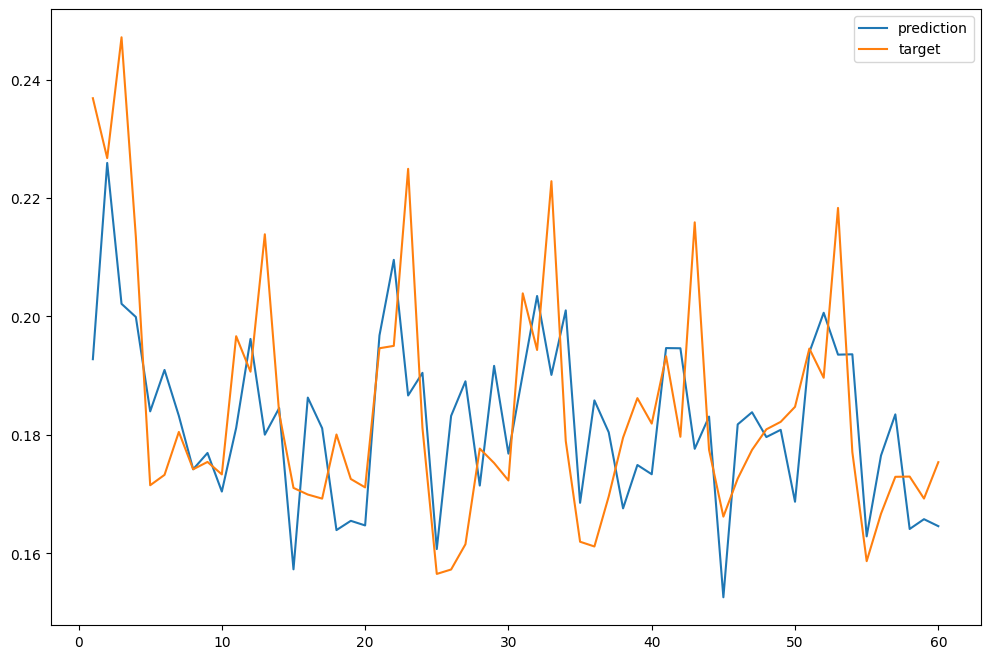

In [16]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [ ]:
np.mean(time_list)